# L2: Text classification

Text classification is the task of sorting text documents into predefined classes. The concrete problem you will be working on in this lab is the classification of texts with respect to their political affiliation. The specific texts you are going to classify are speeches held in the [Riksdag](https://www.riksdagen.se/en/), the Swedish national legislature.

**Before starting with this lab, here is a quick reminder about our [Rules for hand-in assignments](https://www.ida.liu.se/~TDDE16/exam.en.shtml#handins) and the [Policy on cheating and plagiarism](https://www.ida.liu.se/~TDDE16/exam.en.shtml#cheating).**

## Data set

The raw data for this lab comes from [The Riksdag’s Open Data](https://data.riksdagen.se/in-english/). We have tokenized the speeches and put them into two compressed [JSON](https://en.wikipedia.org/wiki/JSON) files:

* `speeches-201718.json.bz2` (speeches from the 2017/2018 parliamentary session)
* `speeches-201819.json.bz2` (ditto, from the 2018/2019 session)

We start by loading these files into two separate data frames.

In [1]:
import pandas as pd
import bz2

with bz2.open('speeches-201718.json.bz2') as source:
    speeches_201718 = pd.read_json(source)
    

with bz2.open('speeches-201819.json.bz2') as source:
    speeches_201819 = pd.read_json(source)

When you inspect the two data frames, you can see that there are three labelled columns: `id` (the official speech ID), `words` (the space-separated words of the speech), and `party` (the party of the speaker, represented by its customary abbreviation).

In [2]:
speeches_201718.head()

,id,words,party
0,H5-002-004,eders majestäter eders kungliga högheter herr ...,S
1,H5-003-001,aktuell debatt om situationen för ensamkommand...,V
2,H5-003-002,herr talman och ledamöter jag vill börja med a...,S
3,H5-003-003,herr talman åhörare den här debatten handlar a...,M
4,H5-003-004,herr talman ansvar och rättssäkerhet är två or...,SD


Throughout the lab, we will be using the speeches from 2017/2018 as our training data, and the speeches from 2018/2019 as our test data.

In [3]:
training_data, test_data = speeches_201718, speeches_201819

For later reference, we store the sorted list of party abbreviations.

In [4]:
parties = sorted(training_data['party'].unique())
print(parties)

#training_data['party'].value_counts().plot(kind='bar')
set1 = training_data['party'].value_counts()
set2 = test_data['party'].value_counts()
print(set1)
print(set2)

['C', 'KD', 'L', 'M', 'MP', 'S', 'SD', 'V']
S     4261
M     2370
MP    1481
SD    1010
V      894
C      865
KD     743
L      719
Name: party, dtype: int64
S     2773
M     1644
SD    1060
V      950
KD     821
MP     809
C      671
L      560
Name: party, dtype: int64


## Problem 1: Visualization

Your first task is to get to know the data better by producing a simple visualization.

If you are not familiar with the Swedish political system and the parties represented in the Riksdag in particular, then we suggest that you have a look at the Wikipedia article about the [2018 Swedish general election](https://en.wikipedia.org/wiki/2018_Swedish_general_election).

For the lab, we ask you to compare the two data frames with respect to the distribution of the speeches over the different parties. Write code to generate two bar plots that visualize this information, one for the 2017/2018 speeches and one for the 2018/2019 speeches. Inspect the two plots, and compare them

* to each other
* to the results of the 2014 and the 2018 general elections

Summarize your observations in a short text in the cell below.

**Tip:** If you need help with creating bar plots, [Bar Plot using Pandas](https://dfrieds.com/data-visualizations/bar-plot-python-pandas) provides a useful tutorial.

For both set of years S and M has the most speeches.

MP has the third most speeches for 17/18 but the third lowest in 18/19.

SD went from 4 most speeches to third most speeches.

The rest of 17/18 speeches were V-C-KD-L
The rest of 18/19 speeches were C-KD-MP-C-L

## Problem 2: Naive Bayes classifier

You are now ready to train and evaluate a classifier. More specifically, we ask you to train a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) classifier. You will have to

1. vectorize the speeches in the training data
2. instantiate and fit the Naive Bayes model
3. evaluate the model on the test data

The scikit-learn library provides a convenience class [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that allows you to solve the first two tasks with very compact code. For the evaluation you can use the function [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), which will report per-class precision, recall and F1, as well as overall accuracy.

In [5]:
# TODO: Write code here to train and evaluate a Multinomial Naive Bayes classifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline


train_X, train_Y = training_data['words'], training_data['party']
pipe = Pipeline([('scaler', CountVectorizer()),('clf', MultinomialNB())])
pipe.fit(train_X, train_Y)
print(classification_report(test_data['party'], pipe.predict(test_data['words']), labels=training_data['party'].unique()))



              precision    recall  f1-score   support

           S       0.46      0.84      0.59      2773
           V       0.59      0.15      0.24       950
           M       0.36      0.68      0.47      1644
          SD       0.57      0.12      0.20      1060
          MP       0.36      0.25      0.29       809
           C       0.63      0.04      0.07       671
           L       0.92      0.02      0.04       560
          KD       0.70      0.02      0.03       821

    accuracy                           0.43      9288
   macro avg       0.57      0.26      0.24      9288
weighted avg       0.52      0.43      0.34      9288



Would you have expected the results that you got?

## Problem 3: Baselines

Evaluation metrics such as accuracy should not be understood as absolute measures of performance, but should be used only to compare different classifiers. When other classifiers are not available, a simple baseline is a classifier that generates predictions by random sampling, respecting the training set&rsquo;s class distribution. This baseline is implemented by the class [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). What is the performance of the random baseline on the test data?

In [6]:
# TODO: Write code here to evaluate the random baseline
from sklearn.dummy import DummyClassifier
random_clf = DummyClassifier(strategy="stratified")
random_clf.fit(test_data['words'],test_data['party'])
randompred = random_clf.predict(test_data['words'])
print(classification_report(test_data['party'], randompred, labels=parties))

              precision    recall  f1-score   support

           C       0.06      0.06      0.06       671
          KD       0.09      0.09      0.09       821
           L       0.03      0.03      0.03       560
           M       0.16      0.17      0.17      1644
          MP       0.09      0.09      0.09       809
           S       0.29      0.29      0.29      2773
          SD       0.12      0.12      0.12      1060
           V       0.10      0.10      0.10       950

    accuracy                           0.16      9288
   macro avg       0.12      0.12      0.12      9288
weighted avg       0.16      0.16      0.16      9288



An even dumber baseline is to predict, for every document, that class which appears most often in the training data. This baseline is also called the most frequent class baseline. What is the accuracy of that baseline on the test data?

In [7]:
# TODO: Write code here to print the accuracy of the most frequent class baseline
frequent_clf = DummyClassifier(strategy="most_frequent")
frequent_clf.fit(test_data['words'],test_data['party'])
frequentpred = frequent_clf.predict(test_data['words'])
print(classification_report(test_data['party'], frequentpred, labels=parties))

/home/stian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           C       0.00      0.00      0.00       671
          KD       0.00      0.00      0.00       821
           L       0.00      0.00      0.00       560
           M       0.00      0.00      0.00      1644
          MP       0.00      0.00      0.00       809
           S       0.30      1.00      0.46      2773
          SD       0.00      0.00      0.00      1060
           V       0.00      0.00      0.00       950

    accuracy                           0.30      9288
   macro avg       0.04      0.12      0.06      9288
weighted avg       0.09      0.30      0.14      9288



/home/stian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Problem 4: Creating a balanced data set

As you saw in Problem&nbsp;1, the distribution of the speeches over the eight different parties (classes) is imbalanced. One technique used to alleviate this is **undersampling**, in which one randomly removes samples from over-represented classes until all classes are represented with the same number of samples.

Implement undersampling to create a balanced subset of the training data. Rerun the evaluation from Problem&nbsp;2 on the balanced data and compare the results. Summarise your results in a short text.

**Hint:** Your balanced subset should consist of 5,752 speeches.

In [8]:
import random
def undersample(original):
    undersampled = original.copy()
    while(len(undersampled) > 5752):
        for index, row in undersampled.iterrows():
            parties = undersampled['party'].value_counts()
            party = parties[row['party']]
    
            if (party > 719):
                randsel = random.random()
                if randsel > 0.5:
                    testdrop = undersampled.drop(index, inplace=True)
    return undersampled        
        

In [9]:
# TODO: Write code here to train and evaluate a Multinomial Naive Bayes classifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

undersampled = undersample(training_data)
train_X, train_Y = undersampled['words'], undersampled['party']
pipe = Pipeline([('scaler', CountVectorizer()),('clf', MultinomialNB())])
pipe.fit(train_X, train_Y)
print(classification_report(test_data['party'], pipe.predict(test_data['words']), labels=training_data['party'].unique()))


              precision    recall  f1-score   support

           S       0.81      0.32      0.46      2773
           V       0.40      0.57      0.47       950
           M       0.42      0.52      0.47      1644
          SD       0.45      0.42      0.43      1060
          MP       0.35      0.40      0.38       809
           C       0.29      0.42      0.34       671
           L       0.27      0.42      0.33       560
          KD       0.30      0.39      0.34       821

    accuracy                           0.42      9288
   macro avg       0.41      0.43      0.40      9288
weighted avg       0.50      0.42      0.42      9288




The classification seems to have improved when the bayes classifier trained on the undersampled dataset. Since the bias towards the parties with more speeches has been removed the classifier also shows less bias towards S.

## Problem 5: Confusion matrix

A **confusion matrix** is a specific table that is useful when analysing the performance of a classifier. In this table, both the rows and the columns correspond to classes, and each cell $(i, j)$ states how many times a sample with gold-standard class $i$ was predicted as belonging to class $j$.

In scitkit-learn, the confusion matrix of a classifier is computed by the function [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). If you would rather see a visual representation, you can also use [`plot_confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

Your task is to use the confusion matrix in order to find, for each given party $p$ in the Riksdag, that other party $p'$ which the classifier that you trained in Problem&nbsp;4 most often confuses with $p$ when it predicts the party of a speaker.

/home/stian/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


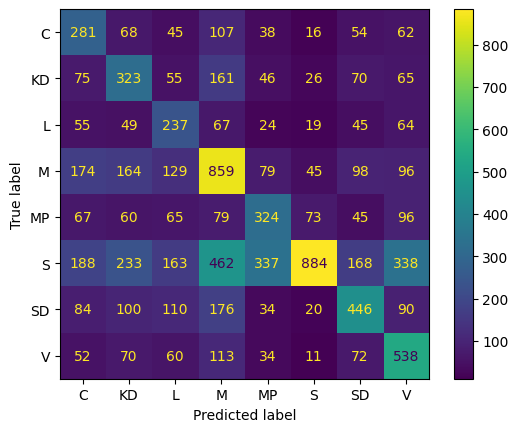

In [10]:
# TODO: Write code here to solve Problem 5
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipe, test_data['words'], test_data['party'])
plt.show()

Take a minute to reflect on whether your results make sense.
C : M
KD : M
L : M
M : C
MP : M
S : M
SD : M
V : M
Results may differ slightly based on the undersampling

## Problem 6: Grid search

Until now, you have been using the vectorizer and the Naive Bayes classifier with their default hyperparameters. When working with real-world applications, you would want to find settings for the hyperparameters that maximize the performance for the task at hand.

Manually tweaking the hyperparameters of the various components of a vectorizer–classifier pipeline can be cumbersome. However, scikit-learn makes it possible to run an exhaustive search for the best hyperparameters over a grid of possible values. This method is known as **grid search**.

The hyperparameters of a pipeline should never be tuned on the final test set. Instead, one should either use a separate validation set, or run cross-validation over different folds. Here we will use cross-validation.

Implement a grid search with 5-fold cross-validation to find the optimal parameters in a grid defined by the following choices for the hyperparameters:

* In the vectorizer, try a set-of-words (binary) model in addition to the default bag-of-words model (two possible parameter values).
* Also in the vectorizer, try extracting bigrams in addition to unigrams (two possible parameter values).
* In the Naive Bayes classifier, try using additive smoothing with $\alpha \in \{1, 0{.}1\}$ (two possible parameter values).

Use the class [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from the scikit-learn library. Print the results of your best model, along with the parameter values that yielded these results.

In [11]:
# TODO: Write code here to implement the grid search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
pipe2 = Pipeline([('vect', CountVectorizer()),('clf', MultinomialNB()) ])
parameters = [
    { 
     'vect__binary':(True, False), 
     'vect__ngram_range':((1,1),(1,2))},
    {'clf__alpha':[0.1,1]}
]
cv = KFold(n_splits=5, shuffle=True, random_state=1)
clf = GridSearchCV(pipe2, parameters, cv=cv)

clf.fit(undersampled['words'], undersampled['party'])
print(clf.best_estimator_)

Pipeline(steps=[('vect', CountVectorizer(binary=True)),
                ('clf', MultinomialNB())])


In [12]:
print(classification_report(test_data['party'], clf.predict(test_data['words']), labels=training_data['party'].unique()))

              precision    recall  f1-score   support

           S       0.78      0.37      0.51      2773
           V       0.43      0.57      0.49       950
           M       0.43      0.52      0.47      1644
          SD       0.47      0.45      0.46      1060
          MP       0.36      0.42      0.39       809
           C       0.32      0.41      0.36       671
           L       0.29      0.41      0.34       560
          KD       0.31      0.43      0.36       821

    accuracy                           0.44      9288
   macro avg       0.42      0.45      0.42      9288
weighted avg       0.51      0.44      0.45      9288



## Problem 7: Try to improve your results

Scikit-learn makes it easy to test different vectorizer–classifier pipelines – among other things, it includes different types of logistic regression classifiers, support vector machines, and decision trees. Browse the library to see which methods are supported.

Build a pipeline that you find interesting, and use grid search to find optimal settings for the hyperparameters. Print the results of your best model.

In [13]:
# TODO: Write code here to search for a better model and print the results
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

parameters = [
    {
        'vect__max_df':[0.25, 0.75], 
        'vect__ngram_range':((1,1),(1,2))
    },
              {'clf__C':[0.1, 1 ,1000]}]

pipeSVM = Pipeline([('vect', TfidfVectorizer()), ('clf', LogisticRegression())])
GSsvm = GridSearchCV(pipeSVM, parameters)

GSsvm.fit(undersampled['words'], undersampled['party'])


/home/stian/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stian/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

GridSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             param_grid=[{'vect__max_df': [0.25, 0.75],
                          'vect__ngram_range': ((1, 1), (1, 2))},
                         {'clf__C': [0.1, 1, 1000]}])

In [14]:
print(GSsvm.best_estimator_)
print(classification_report(test_data['party'], GSsvm.predict(test_data['words']), labels=training_data['party'].unique()))

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(C=1000))])
              precision    recall  f1-score   support

           S       0.70      0.50      0.58      2773
           V       0.52      0.46      0.49       950
           M       0.54      0.45      0.49      1644
          SD       0.44      0.49      0.46      1060
          MP       0.30      0.51      0.38       809
           C       0.35      0.47      0.40       671
           L       0.32      0.46      0.37       560
          KD       0.37      0.36      0.36       821

    accuracy                           0.47      9288
   macro avg       0.44      0.46      0.44      9288
weighted avg       0.51      0.47      0.48      9288



## Reflection questions

The following reflection questions will help you prepare for the diagnostic test. Answer each of them in the form of a short text and put your answers in the cell below. You will get feedback on your answers from your lab assistant.

**RQ 2.1:** Summarise the results of your experiments for Problem&nbsp;2. Are your results ‘good’ or ‘bad’? How do you determine that?

**RQ 2.2:** Summarise the results of your experiments for Problem&nbsp;4. Would you think that your results are typical even for other classification tasks? How would *oversampling* have looked like for this task? When would you use undersampling, when oversampling?

**RQ 2.3:** Which model performed best in your experiments for Problem&nbsp;6? Why is it important to do a hyperparameter search before drawing conclusions about the performance of a model? Why is it often not done, anyway? Why should you never tune hyperparameters on the test set?

RQ 2.1
Our predictor gave the results of an accuracy of 0.43, an macro avarage 0.24 and an weighted avarage of 0.34. Compared to the baseline predictions our results are better. 

The baseline predictor that randomly selects a party gets the accuracy score 0.17, F1 macro avarage score of 0.12 and F1 weighted avarage of 0.17.

The baseline predictor that selects the party that appears most often in out training data gets the accuracy score 0.30, F1 macro avarage score of 0.06 and F1 weighted avarage of 0.14.

We believe that our results are "good" compared to these baselines, however we would need another baseline test, for example how a human would be able to classify, to be able to deem the classifier "good" in its performance.


RQ 2.2
The accuracy is 0.42, macro avarage is 0.40 and the weighted avarage is 0.42 for the F1 score. Compared to the baseline predictions our results are better. 

The baseline predictors results are given in the previous answer.

Would you think that your results are typical even for other classification tasks?
Compared to the not-undersampled predictor our accuract has decreased by 0.01, but the macro avarage and weighted avarage has increased to 0.40 and 0.42 respectively. This is because the bias for overrepresented classes are evened out with the underrepresented classes, resulting in uniform distribution of classifciations. We would expect this for other classifciation tasks as well.

How would oversampling have looked like for this task?
Oversampling would be duplicating random samples from the minority classes. Other techniques would be to copy speeches from previous years for underrepresented classes, implying that these exist. 

When would you use undersampling, when oversampling?
Undersampling should be used when we have enough data so that we can afford to cut down on the overrepresented classes. Oversampling on the other hand should be used if we have less data and cutting down on the overrepresented classes would result in to little data, therefore increasing/duplicating the underrepresented classes is a better strategy.


RQ 2.3
Which model performed best in your experiments for Problem 6?
Based on the parameters the CountVectorizer performed best with binary = true and the MultinomialNB performed best with the default alpa of 1.

Why is it important to do a hyperparameter search before drawing conclusions about the performance of a model?
if you only draw a conculsion based on one set hyperparameter it will be impossible to say that this is the best hyperparamter for your model, given that there are several other hyperparamters that could be better (but are not tested).
If you want to compare models between eachother you want the models to perform hyperparamters search, otherwise you cant draw any conclusions on which model performs the best.

Why is it often not done, anyway?
From our experience from this lab it can be cumbersome to search for several hyperparameters and take alot of time. This is using a small dataset testing only a few hyperparameters, finding the actual best hyperparameter could be much harder and tuning endlessly would give rather small increases in performance with respect to the time and work needed. People may just be satisfied for a given hyperparamter.

Why should you never tune hyperparameters on the test set?
The test sets task is to see how well the model performs on unseen data. By changing the hyperparameters the results we get from testing the model on the test set would be misleading.




**Congratulations on finishing L2! 👍**